# k-NN

by Kirill Bykov, Oleg Vlasovets, Ilya

In [41]:
#imports
import pandas as pd #pandas for reading csv file
import numpy as np  #numpy for vectorising
from random import randrange
import seaborn as sns
from scipy.spatial import distance_matrix
from tqdm import tqdm
import warnings
import math
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_MNIST(file_path):
    df = pd.read_csv(file_path, header = None)
    Y = np.array(df[0])
    X = np.array(df.iloc[:,1:])
    return X, Y

def distance(A, B, metric = "euclidean"):
    if metric == "euclidean":
        return np.linalg.norm(A-B)

def first_most_frequent(arr):
    c = 0
    num = arr[0]
    for i in arr:
        amount_times = arr.count(i)
        if amount_times > c:
            c = amount_times
            num = i
    return num

def accuracy(Y_pred, Y_true):
    return np.mean(1 - np.equal(Y_true, Y_pred, dtype=int))

In [51]:
class kNN:
    
    def __init__(self, X_train, Y_train, p = 2):
        self.X_train = X_train
        self.Y_train = Y_train
        self.length = len(X_train)
        self.p = p
        self.inner_distances_calculated = False

    def vote(self, NN):
        n = len(NN)
        votes = np.zeros(n).astype(int)
        for i in range(0, n):
            votes[i] = first_most_frequent([self.Y_train[j] for j in NN[i]])
        return votes
    
    def predict(self, X_test, k):
        n_test = len(X_test)
        D = np.zeros((n_test, self.length))
        NN = np.zeros((n_test,k)).astype(int)
        D = distance_matrix(X_test, self.X_train, self.p)
        for i in range(0, n_test):
            NN[i] = D[i].argsort()[:k]
        return self.vote(NN)
    
    def LOOCV(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            self.inner_distances = distance_matrix(X_train/100, X_train/100, self.p);
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])
    
    def LOOCV_big(self, k):
        if not self.inner_distances_calculated or self.inner_NN.shape[1]<k:
            print("Calculating distances. This could take some time ...")
            self.inner_NN = []
            for i in tqdm(range(math.trunc(self.length/5000))):
                D = distance_matrix(X_train[5000*i:5000*(i+1)], X_train, self.p);
                NN = D.argsort()[1:k+1]
                self.inner_NN.append(NN)
            self.inner_NN = np.array(self.inner_NN)
        
        return self.vote(self.inner_NN[:,:k])

### a)

In [ ]:
results_test = []
results_train = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
X_test, Y_test = read_MNIST("data/MNIST_test_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred_test = classifier.predict(X_test, k)
    results_test.append(accuracy(Y_pred_test, Y_test))
    
    Y_pred_train = classifier.predict(X_train, k)
    results_train.append(accuracy(Y_pred_train, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=results_test, label = 'Test accuracy')
ax = sns.lineplot(x=[i for i in range(1,21)], y=results_train, label = 'Train accuracy')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  5%|▌         | 1/20 [05:06<1:36:54, 306.00s/it]

Сделайте только картинку получше

## LOOCV

*LOOCV* --- метод, который в первый раз считает расстояния между всеми точками, а затем при различных k использует уже посчитанную матрицу расстояний. Так как в памяти храним все расстояния, работает быстро, но только для маленьгоко датасета

*LOOCV_big* --- метод для работы с большими датасетами, нужно запускать начиная с максимального k, так как на первом запуске держим в памяти только соседей, и не надо пересчитывать это все для маленьких k

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


100%|██████████| 20/20 [01:53<00:00,  5.67s/it]


[0.08066666666666666, 0.08066666666666666, 0.073, 0.073, 0.07833333333333334, 0.079, 0.08166666666666667, 0.08233333333333333, 0.08333333333333333, 0.08866666666666667, 0.088, 0.089, 0.09233333333333334, 0.093, 0.09433333333333334, 0.095, 0.09566666666666666, 0.09566666666666666, 0.098, 0.09833333333333333]


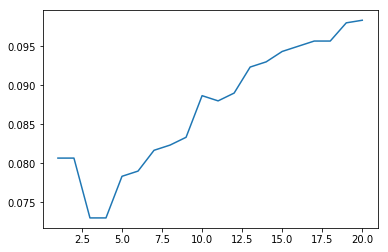

In [4]:
LOOCV_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier.LOOCV(k)
    LOOCV_results.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results)
print(LOOCV_results)

In [ ]:
LOOCV_results_Mink = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for p in tqdm(range(1,16)):
    classifier.p = p
    for k in tqdm(range(1,21)):
        Y_pred = classifier.LOOCV(k)
        LOOCV_results_Mink.append(accuracy(Y_pred, Y_train))
    classifier.inner_distances_calculated = False











  0%|          | 0/15 [00:00<?, ?it/s]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [01:14<23:34, 74.44s/it]










 40%|████      | 8/20 [01:14<10:25, 52.11s/it]










 60%|██████    | 12/20 [01:14<04:51, 36.48s/it]










 75%|███████▌  | 15/20 [01:14<02:07, 25.55s/it]










 90%|█████████ | 18/20 [01:14<00:35, 17.90s/it]










100%|██████████| 20/20 [01:15<00:00,  3.75s/it]









  7%|▋         | 1/15 [01:15<17:30, 75.04s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [01:44<33:10, 104.76s/it]










 40%|████      | 8/20 [01:44<14:40, 73.33s/it] 










 60%|██████    | 12/20 [01:44<06:50, 51.34s/it]










 75%|███████▌  | 15/20 [01:45<02:59, 35.95s/it]










 90%|█████████ | 18/20 [01:45<00:50, 25.18s/it]










100%|██████████| 20/20 [01:45<00:00,  5.27s/it]









 13%|█▎        | 2/15 [03:00<18:13, 84.13s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [04:00<1:16:17, 240.92s/it]










 40%|████      | 8/20 [04:01<33:43, 168.65s/it]  










 60%|██████    | 12/20 [04:01<15:44, 118.06s/it]










 75%|███████▌  | 15/20 [04:01<06:53, 82.66s/it] 










 90%|█████████ | 18/20 [04:01<01:55, 57.87s/it]










100%|██████████| 20/20 [04:01<00:00, 12.08s/it]









 20%|██        | 3/15 [07:01<26:16, 131.35s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [03:47<1:11:59, 227.37s/it]










 40%|████      | 8/20 [03:47<31:49, 159.16s/it]  










 60%|██████    | 12/20 [03:47<14:51, 111.42s/it]










 75%|███████▌  | 15/20 [03:47<06:30, 78.01s/it] 










 90%|█████████ | 18/20 [03:47<01:49, 54.62s/it]










100%|██████████| 20/20 [03:47<00:00, 11.40s/it]









 27%|██▋       | 4/15 [10:49<29:23, 160.34s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [03:58<1:15:37, 238.80s/it]










 30%|███       | 6/20 [03:58<39:00, 167.16s/it]  










 50%|█████     | 10/20 [03:59<19:30, 117.02s/it]










 65%|██████▌   | 13/20 [03:59<09:33, 81.93s/it] 










 80%|████████  | 16/20 [03:59<03:49, 57.36s/it]










 95%|█████████▌| 19/20 [03:59<00:40, 40.17s/it]










100%|██████████| 20/20 [03:59<00:00, 11.98s/it]









 33%|███▎      | 5/15 [14:49<30:41, 184.10s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [03:42<1:10:23, 222.27s/it]










 40%|████      | 8/20 [03:42<31:07, 155.59s/it]  










 60%|██████    | 12/20 [03:42<14:31, 108.92s/it]










 75%|███████▌  | 15/20 [03:42<06:21, 76.26s/it] 










 90%|█████████ | 18/20 [03:42<01:46, 53.39s/it]










100%|██████████| 20/20 [03:42<00:00, 11.14s/it]









 40%|████      | 6/15 [18:32<29:21, 195.73s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...













  5%|▌         | 1/20 [04:00<1:16:02, 240.11s/it]










 45%|████▌     | 9/20 [04:00<30:48, 168.08s/it]  










 65%|██████▌   | 13/20 [04:00<13:43, 117.67s/it]










 80%|████████  | 16/20 [04:00<05:29, 82.38s/it] 










 95%|█████████▌| 19/20 [04:00<00:57, 57.68s/it]










100%|██████████| 20/20 [04:00<00:00, 12.04s/it]









 47%|████▋     | 7/15 [22:33<27:53, 209.23s/it]










  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


[0.9046666666666666, 0.9046666666666666, 0.9063333333333333, 0.9123333333333333, 0.9093333333333333, 0.912, 0.918, 0.9113333333333333, 0.9083333333333333, 0.9053333333333333, 0.9093333333333333, 0.9073333333333333, 0.9066666666666666, 0.9083333333333333, 0.9043333333333333, 0.9036666666666666, 0.905, 0.9023333333333333, 0.9046666666666666, 0.902, 0.901, 0.901, 0.9046666666666666, 0.91, 0.9073333333333333, 0.9066666666666666, 0.903, 0.903, 0.8983333333333333, 0.894, 0.8903333333333333, 0.892, 0.8943333333333333, 0.8976666666666666, 0.897, 0.8973333333333333, 0.896, 0.8976666666666666, 0.8973333333333333, 0.8963333333333333, 0.898, 0.898, 0.8913333333333333, 0.8916666666666667, 0.889, 0.8923333333333333, 0.8916666666666667, 0.897, 0.895, 0.891, 0.888, 0.885, 0.8873333333333333, 0.8846666666666667, 0.8823333333333333, 0.882, 0.8846666666666667, 0.8843333333333333, 0.8863333333333333, 0.888, 0.892, 0.892, 0.892, 0.889, 0.886, 0.8853333333333333, 0.887, 0.8876666666666667, 0.891333333333333

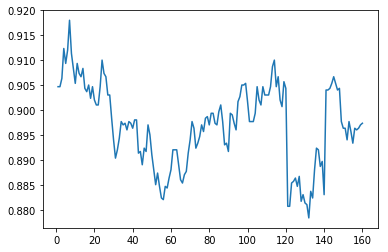

In [33]:
ax = sns.lineplot(x=[i for i in range(1,161)], y=LOOCV_results_Mink)
print(LOOCV_results_Mink)

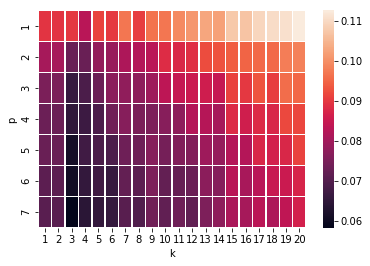

In [14]:
ax = sns.heatmap(np.reshape(LOOCV_results_Mink[:140], (7,20)), linewidth=0.5)
plt.xlabel('k')
plt.ylabel('p')
ax.set_xticklabels(range(1,21))
ax.set_yticklabels(range(1,8))
plt.show()

In [24]:
LOOCV_results_full = []
X_train, Y_train = read_MNIST("../../MNIST_train.csv")

In [28]:
classifier = kNN(X_train, Y_train)

for k in tqdm(range(20,0,-1)):
    Y_pred = classifier.LOOCV_big(k)
    LOOCV_results_full.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results_full)
print(LOOCV_results_full)





  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...







  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 